## **Food-101 Classifier using ResNet50**
---

* **By:** Onur Özbek
* **Platform:** Google Colab Pro
* **Date of Completion:** June 14, 2020
* **SoTA:** 88% top-1
    
Colab Pro Hardware Specs:
* **GPU:** Tesla P100
* **Storage:** 30GB
* **RAM:** 25.5GB

The shell commands below install the necessary packages. I had to downgrade PyTorch and Torchvision due to compatibility issues with Colab.

In [0]:
%reload_ext autoreload
%autoreload 2

!apt-get update
!apt install wget
!pip install pathlib
!pip install fastai
!pip install "torch==1.4" "torchvision==0.5.0"

The following are my imports. I've decided to use the FastAI library. Jeremy Howard had a great lecture on building classifiers. It is a simple library that allows developers to make use of PyTorch and it thought me a lot about multilabel classification.

Right underneath the imports, I also have the Label Smoothing class. Label smoothing has only been added to FastAI 2.0 beta at the time of this notebook so I had to manually include it.

In [0]:
import torch
import torch.nn as nn
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from pathlib import Path
import os, shutil

from torch.distributions.beta import Beta

def lin_comb(a, b, frac_a): return (frac_a * a) + (1 - frac_a) * b

def unsqueeze(input, dims):
    for dim in listify(dims): input = torch.unsqueeze(input, dim)
    return input

def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, ε:float=0.1, reduction='mean'):
        super().__init__()
        self.ε,self.reduction = ε,reduction

    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return lin_comb(loss/c, nll, self.ε)

# **Assembling the Dataset**
---

Because I'm using Colab Pro, I have to import my dataset each time I run the notebook. I was able to find the Food-101 dataset on AWS thanks to fastAI because ETH Zurich was no longer hosting the dataset on its website (https://vision.ee.ethz.ch/datasets_extra/food-101/). The code below downloads the tar file, extracts, renames and reassembles the images based on the data from **train.txt** and **test.txt** files. I prefer to keep all my train images in **food-101/images/train** and all my test images in **food-101/images/test**. I also move all of my meta files to **food-101/meta**.

In [0]:
# Removing the default sample_data directory that comes with every new Colab instance
!rm -rf sample_data

# Removes the existing food-101 dataset for a fresh, complete download
!rm -rf food-101 

# Downloads the food-101 dataset tar file
!wget https://s3.amazonaws.com/fast-ai-imageclas/food-101.tgz 

# Untars the tar file
!tar -xvf food-101.tgz 

# Removes the redundant h5 directory
!rm -rf food-101.tgz food-101/h5/

# Creates the meta, train and test directories inside food-101/images
!mkdir food-101/meta food-101/images/train food-101/images/test

# Moves all .txt and .json files to the meta directory
!mv food-101/*.txt food-101/*.json food-101/meta/ 

# Moves all test images to the food-101/images/test directory and renames them.
with open('food-101/meta/test.txt') as test_file:
  for line in test_file:
    name_of_folder = line.split('/')[0]
    name_of_file = line.split('/')[1].rstrip()
    Path('food-101/images/' + name_of_folder + '/' + name_of_file + '.jpg').rename('food-101/images/test/' + name_of_folder + '_' + name_of_file + '.jpg')

# Moves all training images to the food-101/images/train directory and renames them.
with open('food-101/meta/train.txt') as train_file:
  for line in train_file:
    name_of_folder = line.split('/')[0]
    name_of_file = line.split('/')[1].rstrip()
    Path('food-101/images/' + name_of_folder + '/' + name_of_file + '.jpg').rename('food-101/images/train/' + name_of_folder + '_' + name_of_file + '.jpg')

# Removes empty directories inside Food-101/images.
with open('food-101/meta/train.txt') as train_file:
  for folder in train_file:
    name_of_folder = folder.split('/')[0]
    if os.path.exists('food-101/images/' + name_of_folder):
      shutil.rmtree('food-101/images/' + name_of_folder)

Running shell commands to see if I've partitioned the train and test images correctly. There need to be 75,750 training images and 25,250 test images.

In [0]:
%cd /content/food-101/images/train/
!ls -1 | wc -l

%cd ../test
!ls -1 | wc -l

%cd /content/

/content/food-101/images/train
75750
/content/food-101/images/test
25250
/content


# **Building the Model**
---

Because every image in the entire dataset comes labelled, I've decided to use the names of each image as classes for the classifier via regex. I am training the model with 20% of the training set as my validation set.  For data augmentation, I am using fastAI's `.get_transforms()` function because the transformations are done on the fly so there isn't a drastic increase in the dataset size and the randomness is taken care of by the fastAI library.  I am reducing each image to size 224 for better training.  The batch size is 8 because I don't want to exceed the memory limit on CUDA (I've had issues with this when I was using larger batch sizes). I'm using `.normalize(imagenet_stats)` to easily normalize the data based on the RGB channels' stats from the ImageNet dataset.

In [0]:
np.random.seed(42)
batch_size = 8

path = 'food-101/images/train'
file_parse = r'/([^/]+)_\d+\.(png|jpg|jpeg)$'

data = ImageList.from_folder(path).split_by_rand_pct(valid_pct=0.2).label_from_re(pat=file_parse).transform(get_transforms(), size=224).databunch(bs = batch_size).normalize(imagenet_stats)

In my learner where I've added ResNet50 as my base architecture, I'm using accuracy for my metric and I'm measuring for top-1. I'm also applying Label smoothing to my model. Label smoothing helps train the model around misclassified data to improve its performance. While it causes the model to learn incorrectly by a lesser percentage, it also decreases the loss. When I relaxed confidence around the labels, I saw that the model was performing much better against the test set.

In [0]:
top_1 = partial(top_k_accuracy, k=1)
learn = cnn_learner(data, models.resnet50, metrics=[accuracy, top_1], loss_func = LabelSmoothingCrossEntropy(), callback_fns=ShowGraph)

# **Training**
---

This is the training phase of my model. Before I run a set of epochs, I start by finding a learning rate. I added `suggestion=True` to approximate the interval I'll be selecting.  In the below case, the optimal learning rate was around **1e-06**.


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.91E-03


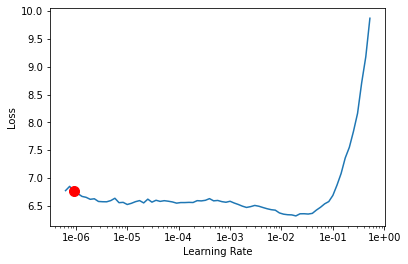

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

Based on the suggestion from the learning rate finder, I am getting a slice for the learning rate between **1e-06** and **1e-04**.  I'm running 5 epochs on this learning rate and saving the weights as *stage-1*.  The model accuracy progresses in the first run.  By the end of the 5th epoch, the model improved from 40.7% accuracy to 58.5%.  

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.859916,2.895566,0.407987,0.407987,10:21
1,3.129739,2.482539,0.520792,0.520792,10:32
2,3.004577,2.338441,0.559406,0.559406,10:39
3,2.660794,2.251707,0.583828,0.583828,10:48
4,2.634115,2.243142,0.585677,0.585677,10:45


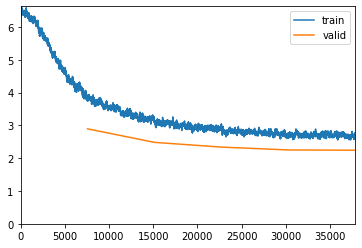

In [0]:
learn.fit_one_cycle(5, max_lr=slice(1e-06, 1e-04))
learn.save('stage-1')

Now I'm finding a new learning rate to run another set of epochs.  I'm doing the same thing as above.  One thing that I always do is that at the end of each 5 epoch cycles, I unfreeze the model.  In this case, my learning rate was roughly around **1e-041**.

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-05
Min loss divided by 10: 1.10E-05


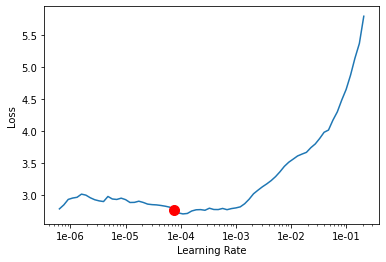

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

I ran another 5 epochs and saved it as *stage-2*. The model's accuracy was increasing as fast as it was in *stage-1* but this time, it intercepts with the validation line.

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.501828,2.073757,0.641320,0.641320,11:12
1,2.235237,1.922365,0.699670,0.699670,11:22
2,2.020066,1.838783,0.738614,0.738614,11:15
3,1.760592,1.760703,0.768119,0.768119,11:16
4,1.724652,1.707020,0.773333,0.773333,11:13


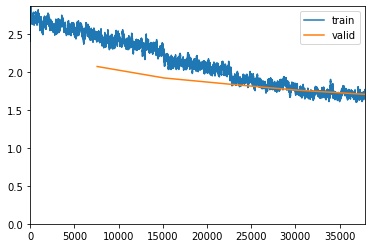

In [0]:
learn.fit_one_cycle(5, max_lr=slice(1e-05, 1e-04))
learn.save('stage-2')

I wanted to see if I could squeeze out better accuracy.  To do this, I recreated the data bunch object.  I kept it the same as the earlier declaration except that here, I increased the image size from 224 to 512.  I also wanted to load *stage 2* to run the learning rate finder.

In [0]:
data = ImageList.from_folder(path).split_by_rand_pct(valid_pct=0.2).label_from_re(pat=file_parse).transform(get_transforms(), size=512).databunch(bs = batch_size).normalize(imagenet_stats)
learn = cnn_learner(data, models.resnet50, metrics=[accuracy, top_1], loss_func = LabelSmoothingCrossEntropy(), callback_fns=ShowGraph)

learn.load('stage-2')

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-05
Min loss divided by 10: 1.32E-07


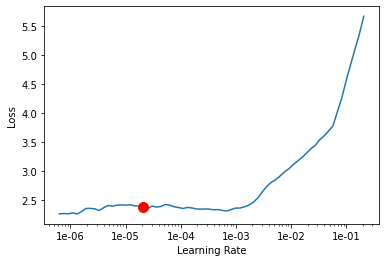

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

I ran another set of 5 epochs on the new learning rate. My last set of epochs gave me an accuracy score of 77.3% but after increasing the image size, I reached 84.2% accuracy.  Training time increased significantly (from 11 minutes per epoch to 30 minutes) because I've increased the image size.

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.883501,1.643857,0.791485,0.791485,30:55
1,1.820899,1.650063,0.788515,0.788515,30:54
2,1.653010,1.555965,0.817162,0.817162,30:54
3,1.493082,1.494516,0.835248,0.835248,30:54
4,1.370035,1.481267,0.842508,0.842508,30:54


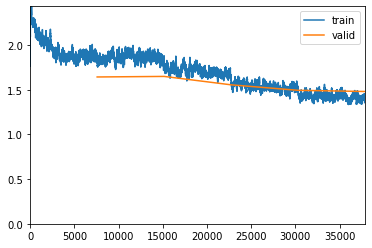

In [0]:
learn.fit_one_cycle(5, max_lr=slice(1e-05, 1e-04))
learn.save('stage-3')

Although the curve is starting to straighten, I wanted to run an additional set of 5 epochs to get the most accuracy out of my model so I ran a new learning rate finder.

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06
Min loss divided by 10: 1.45E-06


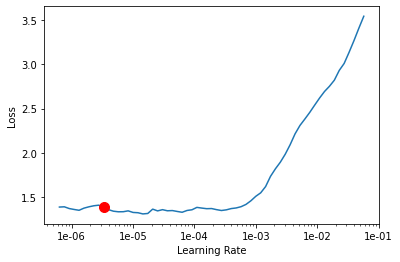

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.467199,1.475933,0.834653,0.834653,30:54
1,1.445557,1.466907,0.837426,0.837426,30:55
2,1.342796,1.430450,0.843300,0.843300,30:56
3,1.291746,1.419097,0.847129,0.847129,30:55
4,1.238182,1.410005,0.846931,0.846931,30:55


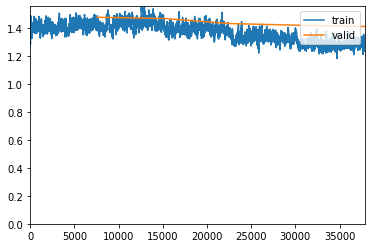

In [0]:
learn.fit_one_cycle(5, max_lr=slice(1e-06, 1e-04))
learn.save('stage-4')

It doesn't look like I'm going to get better than 84.7% accuracy during training. If I were to run additional epochs, the graph would just oscillate. 

# **Mispredictions**
---

I wanted to see which images caused the most problems for the model. When it comes to food, there is a lot of visual overlap. For example, it isn't weird for a model to be confused between steak with gravy and some pudding-like dessert due to the similarities in colour, shape, texture, etc.

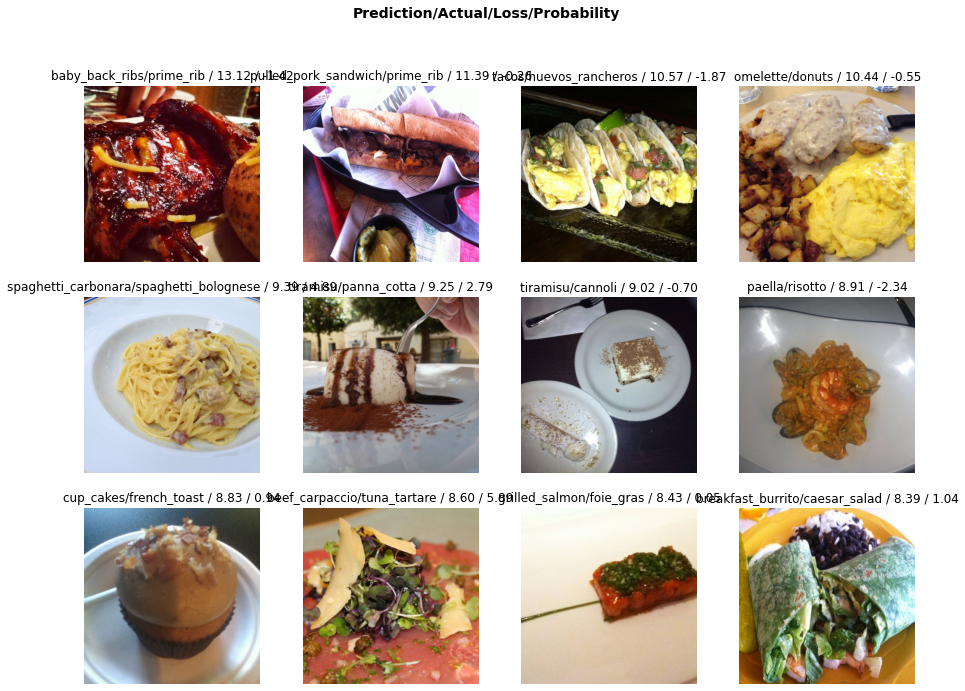

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(12, figsize=(15, 11))

In [0]:
interp.most_confused(min_val=5)

[('filet_mignon', 'steak', 26),
 ('chocolate_mousse', 'chocolate_cake', 24),
 ('steak', 'filet_mignon', 22),
 ('donuts', 'beignets', 19),
 ('prime_rib', 'steak', 19),
 ('beef_tartare', 'tuna_tartare', 15),
 ('dumplings', 'gyoza', 15),
 ('chocolate_mousse', 'tiramisu', 14),
 ('chocolate_cake', 'chocolate_mousse', 13),
 ('pork_chop', 'steak', 13),
 ('apple_pie', 'bread_pudding', 12),
 ('ice_cream', 'frozen_yogurt', 12),
 ('grilled_salmon', 'pork_chop', 11),
 ('sushi', 'sashimi', 11),
 ('baby_back_ribs', 'steak', 10),
 ('chocolate_mousse', 'panna_cotta', 10),
 ('ramen', 'pho', 10),
 ('tiramisu', 'chocolate_mousse', 10),
 ('tuna_tartare', 'beef_tartare', 10),
 ('bread_pudding', 'apple_pie', 9),
 ('breakfast_burrito', 'huevos_rancheros', 9),
 ('lobster_bisque', 'clam_chowder', 9),
 ('apple_pie', 'baklava', 8),
 ('chicken_quesadilla', 'breakfast_burrito', 8),
 ('hamburger', 'pulled_pork_sandwich', 8),
 ('tuna_tartare', 'ceviche', 8),
 ('baby_back_ribs', 'pork_chop', 7),
 ('chocolate_cake', '

When I look at the output of `.most_confused()`, I can see that the model's confusion was between food that have little to no physical distinction.  For example, the biggest confusion was between filet mignon and steak.  Filet mignon and steak are actually the same thing. Steak is just a broad range of beef cuts and filet mignon is just the cut from the smaller end of the tenderloin.

Its usually my habit to include a confusion matrix as well but each time I tried to include one, the kernel would just die and all of my variables would be lost so I decided to go without it.

# **Testing**
---

Now its time to test the trained model. I created the new data bunch variable `data_test`.  It is the same as above except that in the `split_by_folder()`, I've added the test images.

I chose `learn.validate()` as my accuracy method.  The reason why is that `learn.validate()` is used if there is an existing validation set and validation sets are always labelled.  The fastAI library takes the test sets blindly even if the test images have labels so I can't calculate the accuracy on tha alone. It made more sense for me to create a new data bunch object where I include my test set like a validation set (`split_by_folder(train='train', valid='test')`) and compare my trained model against it.

In [0]:
path = '/content/food-101/images'

data_test = ImageList.from_folder(path).split_by_folder(train='train', valid='test').label_from_re(file_parse).transform(size=512).databunch().normalize(imagenet_stats)

learn = cnn_learner(data, models.resnet50, metrics=[accuracy, top_1],callback_fns=ShowGraph)
learn.load('stage-4')

The validation gives me a SoTA of 88.1% ≈ 88%

In [0]:
learn.validate(data_test.valid_dl)

[0.5012631, tensor(0.8809), tensor(0.8809)]